In [2]:
import sys

sys.path.append("../../src/groundstate_prep")
from fuzzy_bisection import fuzzy_bisection, fuzzy_bisection_noisy
from ground_state_prep import prepare_ground_state
from ground_state_prep_qiskit import qetu_rqc_oneLayer

sys.path.append("../../src/lindbladian")
from lindbladian import circuit_implementation_lindbladian

In [3]:
# Hamiltonian.

import numpy as np
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt

# Parameters for the Ising Hamiltonian
# L has to be even! Due to K only being able to control even Ls!
L, J, g = (6, 1, 1)


# construct Hamiltonian
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
hamil = qib.IsingHamiltonian(field, J, 0, g).as_matrix().toarray()

eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]
print("Ground State Energy", eigenvalues_sort[0].real)

dist = 0.001
max_spectrum_length = 16
ground_energy_lower_bound = -10
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

print("a_max", a_values[0])
print("a_premax", a_values[1])
print("c1: ", c1)
print("c2: ", c2)

Ground State Energy -7.727406610312517
a_max (0.9751344744696504-0j)
a_premax (0.9690846890527383-0j)
c1:  0.19622454084936208
c2:  1.9632454084936208


Absolute Error for the Eigenvalue:  0.5830838054621958


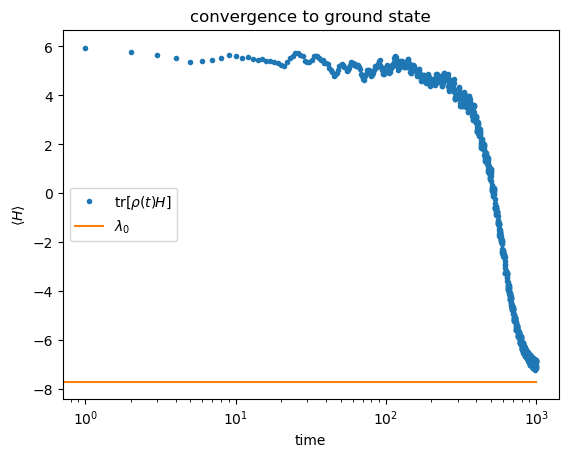

dt:  0.09811227042468104
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.27509349682562917+0j)
Time evolution encoding, absolute error:  7.748613345603324e-07

Layer 0
Prob 0: 0.21993717702032886
Prob 1: 0.7800628229796674

Layer 1
Prob 0: 0.2621291975565953
Prob 1: 0.7378708024433996

Layer 2
Prob 0: 0.26874152014636926
Prob 1: 0.7312584798536255

Layer 3
Prob 0: 0.27204028088155074
Prob 1: 0.7279597191184451

Layer 4
Prob 0: 0.27363554313829463
Prob 1: 0.7263644568617003

F(a_max) = (0.27509349682562917+0j)

 ---------- 
 SUCCESS! 

Fidelity of the initial state to the ground state: 0.7291029018103746
Fidelity of the prepared state to the ground state: 0.9954195206189199


In [12]:
# Prepare the ground state with Lindbladian + QETU

mu, d, c, phis_max_iter, = (0.97, 30, 0.9, 10)

tau, nsteps = (1,1000)
end_state_lind, en_list, err = circuit_implementation_lindbladian(hamil, L, tau=tau, nsteps=nsteps)

print("Absolute Error for the Eigenvalue: ", err)
plt.semilogx(tau * np.arange(nsteps + 1), en_list, ".", label=r"$\mathrm{tr}[\rho(t) H]$")
plt.semilogx(tau * np.arange(nsteps + 1), (eigenvalues_sort[0]*np.ones(nsteps + 1)).real, label=r"$\lambda_0$")
plt.legend()
plt.xlabel("time")
plt.ylabel(r"$\langle H \rangle$")
plt.title("convergence to ground state")
plt.show()
#end_state_lind = np.array([1 if i==0 else 0 for i in range(2**L)])
qc_qetu, phis_0 = qetu_rqc_oneLayer(L, J, g, c1/2, mu, a_values, d=d, c=c, c2=c2, max_iter_for_phis=phis_max_iter)

ket_0 = np.array([1,0])

end_state_qetu, E = prepare_ground_state(
                        np.kron(ket_0, end_state_lind), mu, d, c, phis_max_iter,
                        np.kron(ket_0, ground_state), L, J, g, eigenvalues_sort[0],
                        hamil=hamil, max_reps=5, tau=c1, shift=c2, a_max=a_values[0]
)



In [97]:
# We can make max_spectrum_length arbitrarily small and approximate the eigenvalue
# digit by digit. This increases the c1 every time by 10 times, hence increasing circuit
# depth by 10 times. RQCOpt can fix this!

previous_estimate = -8

x_exp = []
for digit in range(0, 6):
    dist = 1e-20
    print(digit)
    max_spectrum_length = 10**(-digit)
    previous_estimate = np.round(previous_estimate, digit)
    print("Previous Estimate: ", previous_estimate)
    ground_energy_lower_bound = previous_estimate - max_spectrum_length
    c1 = (np.pi-2*dist) / (max_spectrum_length)
    c2 = dist - c1 * ground_energy_lower_bound
    print("c1 ", c1)
    print("c2 ", c2)

    eigenvalues_tr = eigenvalues_sort * c1 + c2
    a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])
    
    # Assuming we can approximate a_max up to one digit 
    # precision after comma at each fuzzy bisection search.
    a_est = np.round(a_values[0], 2)
    est_eig = 2*np.arccos(a_est)
    print("ground_energy_lower_bound", ground_energy_lower_bound)
    print("lambda-lambda_LB * 10^(-d}):", (eigenvalues_sort[0] - ground_energy_lower_bound)/max_spectrum_length)
    x_exp.append((eigenvalues_sort[0] - ground_energy_lower_bound)/max_spectrum_length)
    previous_estimate = (est_eig - c2)/c1
    print("exact a", a_values[0])
    print("Estimated a: ", a_est)
    print("Estimated x:", 2/np.pi*np.arccos(a_est))
    print("Estimated Eigenvalue: ", previous_estimate)
    print("Exact Eigenvalue", eigenvalues_sort[0])
    print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
    print("----------------------------------------")

0
Previous Estimate:  -8
c1  3.141592653589793
c2  28.274333882308138
ground_energy_lower_bound -9
lambda-lambda_LB * 10^(-d}): (1.2725933896874828+0j)
exact a (-0.41522370549113996-0j)
Estimated a:  (-0.42-0j)
Estimated x: (1.2759398609966843+0j)
Estimated Eigenvalue:  (-7.724060139003316+0j)
Exact Eigenvalue (-7.727406610312517+0j)
Absolute Error:  (0.003346471309201071+0j)
----------------------------------------
1
Previous Estimate:  (-7.7+0j)
c1  31.41592653589793
c2  (245.04422698000386+0j)
ground_energy_lower_bound (-7.8+0j)
lambda-lambda_LB * 10^(-d}): (0.7259338968748263+0j)
exact a (0.41732707621499543-0j)
Estimated a:  (0.42-0j)
Estimated x: (0.7240601390033158+0j)
Estimated Eigenvalue:  (-7.727593986099668+0j)
Exact Eigenvalue (-7.727406610312517+0j)
Absolute Error:  (-0.0001873757871511117+0j)
----------------------------------------
2
Previous Estimate:  (-7.73+0j)
c1  314.1592653589793
c2  (2431.5927138785+0j)
ground_energy_lower_bound (-7.74+0j)
lambda-lambda_LB * 10^(-

In [18]:
# We go one digit further, assuming we know the lower bound to be -7.75 through previous
# approximations!

dist = 0.001
max_spectrum_length = 1

# Initial search starts with a larger margin, hence multiplication with 2!
# Estimation -6 is acquired through expectation value measurement!
ground_energy_lower_bound = -6 - 2*max_spectrum_length
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound
c2 = c2

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

a_est = 0.89
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)
print("Exact a: ", a_values[0])

print("c1: ", c1)

Absolute Error:  (0.028688470385234588+0j)
Estimated Eigenvalue:  -7.698718139927295
Exact a:  (0.9096248901196278-0j)
c1:  3.1395926535897933


In [ ]:
# Divide up the time step and repeat the circuit! Depolarizing error: 1e-3!

a_est = fuzzy_bisection_noisy(qc_qetu, L, J, g, 0, 1, 34, 1e-3, 0, c1, c2, a_values, 1e-3, RQC_layers=7, qetu_initial_state=np.kron(ket_0, end_state_lind), nshots=1e4, split_U=1, qetu_layers=5, ground_state=eigenvectors_sort[:, 0])
print("Estimated a: " + str(a_est))
print("a: " + str(a_values[0]))

In [17]:
# We demonstrate that we approximated the eigenvalue until the third digit!

a_est = 0.88
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)

0.88
0.989868252681791
Absolute Error:  (0.04237366552942934+0j)
Estimated Eigenvalue:  -7.6850329447831


In [19]:
# We go one digit further, assuming we know the lower bound to be -7.75 through previous
# approximations!

dist = 0.001
max_spectrum_length = 0.1
ground_energy_lower_bound = -7.7 - max_spectrum_length
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound
c2 = c2

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

a_est = 0.42
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)
print("Exact a: ", a_values[0])
print("c1:", c1)

Absolute Error:  (-0.00017310258906899634+0j)
Estimated Eigenvalue:  -7.727579712901599
Exact a:  (0.41753238442639495-0j)
c1: 31.39592653589793


In [ ]:
# Divide up the time step and repeat the circuit! Depolarizing error: 1e-3!

a_est = fuzzy_bisection_noisy(qc_qetu, L, J, g, 0,  1, 34, 1e-3, 0, c1, c2, a_values, 1e-3, qetu_initial_state=np.kron(ket_0, end_state_lind), nshots=1e4, qetu_layers=5, ground_state=eigenvectors_sort[:, 0])
print("Estimated a: " + str(a_est))
print("a: " + str(a_values[0]))

------------------
x: 0.5
d:  34
left:  0
right:  1
dt:  1.046530884529931
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.0003072071007159508+0j)
Time evolution encoding, absolute error:  0.0007169184480852605
state_fidelity: 0.9954195255150531
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'cx', 'cu', 'cz', 'cy', 'rz', 'sx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'rz', 'sx', 'cu', 'cx', 'cy', 'cz']
Success Prob:  0.2423
------------------
x: 0.255
d:  34
left:  0
right:  0.51
dt:  1.046530884529931
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.7738906386765607+0j)
Time evolution encoding, absolute error:  0.0007169184480852605
state_fidelity: 0.9954195255150529
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'cx', 'cu', 'cz', 'cy', 'rz', 'sx', 'u3', 'u1']
  All-

In [27]:
# We demonstrate that we approximated the eigenvalue until the third digit!

a_est = 0.40046875
est_eig = 2*np.arccos(a_est)
print(a_est)
print(est_eig)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)

0.40046875
2.317535950861689
Absolute Error:  (0.00034445633475588266+0j)
Estimated Eigenvalue:  -7.727062153977774


In [20]:
# We go one digit further, assuming we know the lower bound to be -7.7271 through previous
# approximations!

dist = 0.001
max_spectrum_length = 0.001
ground_energy_lower_bound = -7.727 - max_spectrum_length
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound
c2 = c2

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

a_est = 0.55
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)
print("Exact a: ", a_values[0])
print("c1", c1)

Absolute Error:  (3.594806295126318e-05+0j)
Estimated Eigenvalue:  -7.727370662249578
Exact a:  (0.5962287837278712-0j)
c1 3139.5926535897934


In [ ]:
# Divide up the time step and repeat the circuit! Depolarizing error: 1e-3!

a_est = fuzzy_bisection_noisy(qc_qetu, L, J, g, 0,  1, 34, 1e-3, 0, c1, c2, a_values, 1e-3, qetu_initial_state=np.kron(ket_0, end_state_lind), nshots=1e4, split_U=20, RQC_layers=11, qetu_layers=5, ground_state=eigenvectors_sort[:, 0])
print("Estimated a: " + str(a_est))
print("a: " + str(a_values[0]))

------------------
x: 0.5
d:  34
left:  0
right:  1
dt:  78.48981633974483
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.8890779306204775+0j)
Time evolution encoding, absolute error:  2.832633071363232e-06
state_fidelity: 0.9954195254166436
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'cy', 'cu', 'u2', 'u1', 'cx', 'cz', 'sx', 'rz']
  All-qubits errors: ['u1', 'u2', 'u3', 'rz', 'sx', 'cu', 'cx', 'cy', 'cz']
Success Prob:  0.7444
------------------
x: 0.745
d:  34
left:  0.49
right:  1
dt:  78.48981633974483
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.003284468931710479+0j)
Time evolution encoding, absolute error:  2.832633071363232e-06
state_fidelity: 0.995419525416645
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'cy', 'cu', 'u2', 'u1', 'cx', 'cz', 'sx', 'rz']
  All-qu

In [6]:
# The run above will get stuck around the given interval.
# We demonstrate that we approximated the eigenvalue until the fourth digit!

a_est = 0.5765625
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)

Absolute Error:  (1.5467072699060225e-05+0j)
Estimated Eigenvalue:  -7.727391143239831


In [4]:
# We go one digit further, assuming we know the lower bound to be -7.72741 through previous
# approximations!

dist = 0.001
max_spectrum_length = 0.0001
ground_energy_lower_bound = -7.7274 - max_spectrum_length
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound
c2 = c2

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

a_est = 0.15
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)
print("Exact a: ", a_values[0])

print("c1: ", c1)

Absolute Error:  (-2.9494163484855562e-06+0j)
Estimated Eigenvalue:  -7.727409559728878
Exact a:  (0.10407961312991994-0j)
c1:  31395.926535897932


In [ ]:
# Divide up the time step and repeat the circuit! Depolarizing error: 1e-3!

a_est = fuzzy_bisection_noisy(qc_qetu, L, J, g, 0,  1, 34, 1e-3, 0, c1, c2, a_values, 1e-3, qetu_initial_state=np.kron(ket_0, end_state_lind), nshots=1e4, split_U=20, RQC_layers=11, qetu_layers=5, ground_state=eigenvectors_sort[:, 0])
print("Estimated a: " + str(a_est))
print("a: " + str(a_values[0]))

------------------
x: 0.5
d:  34
left:  0
right:  1
dt:  784.8981633974483
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.0002008680662934722+0j)
Time evolution encoding, absolute error:  6.844680321282185e-07
state_fidelity: 0.9954195286252543
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cu', 'sx', 'rz', 'u3', 'cz', 'u2', 'u1', 'cx', 'cy']
  All-qubits errors: ['u1', 'u2', 'u3', 'rz', 'sx', 'cu', 'cx', 'cy', 'cz']
Success Prob:  0.2444
------------------
x: 0.255
d:  34
left:  0
right:  0.51
dt:  784.8981633974483
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.002652606784816739+0j)
Time evolution encoding, absolute error:  6.844680321282185e-07
state_fidelity: 0.9954195286252563
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cu', 'sx', 'rz', 'u3', 'cz', 'u2', 'u1', 'cx', 'cy']
  Al

In [5]:
# The run above will get stuck around the given interval.
# We demonstrate that we approximated the eigenvalue until the fifth digit!

a_est = 0.07125
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)

Absolute Error:  (2.0995093699127665e-06+0j)
Estimated Eigenvalue:  -7.72740451080316


In [5]:
# We go one digit further, assuming we know the lower bound to be -7.727401 through previous
# approximations!

dist = 0.001
max_spectrum_length = 1e-5
ground_energy_lower_bound = -7.72740 - max_spectrum_length
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound
c2 = c2

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

a_est = 0.8
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)
print("Exact a: ", a_values[0])

print("c1: ", c1)

Absolute Error:  (7.063923694872187e-07+0j)
Estimated Eigenvalue:  -7.72740590392016
Exact a:  (0.8614837293906226-0j)
c1:  313959.2653589793


In [ ]:
# Divide up the time step and repeat the circuit! Depolarizing error: 1e-3!

a_est = fuzzy_bisection_noisy(qc_qetu, L, J, g, 0,  1, 34, 1e-3, 0, c1, c2, a_values, 1e-3, qetu_initial_state=np.kron(ket_0, end_state_lind), nshots=1e4, split_U=20, RQC_layers=9, qetu_layers=5, ground_state=eigenvectors_sort[:, 0])
print("Estimated a: " + str(a_est))
print("a: " + str(a_values[0]))

------------------
x: 0.5
d:  34
left:  0
right:  1
dt:  7848.981633974482
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.870910253455057+0j)
Time evolution encoding, absolute error:  7.938896053190815e-07
state_fidelity: 0.9954195252396205
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['sx', 'u3', 'cx', 'u2', 'cy', 'rz', 'u1', 'cz', 'cu']
  All-qubits errors: ['u1', 'u2', 'u3', 'rz', 'sx', 'cu', 'cx', 'cy', 'cz']
Success Prob:  0.7155
------------------
x: 0.745
d:  34
left:  0.49
right:  1
dt:  7848.981633974482
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.7931231502309293+0j)
Time evolution encoding, absolute error:  7.938896053190815e-07
state_fidelity: 0.9954195252396207
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['sx', 'u3', 'cx', 'u2', 'cy', 'rz', 'u1', 'cz', 'cu']
  All-qubi

In [6]:
# The run above will get stuck around the given interval.
# We demonstrate that we approximated the eigenvalue until the sixth digit!

a_est = 0.836875
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)

Absolute Error:  (2.970783006261968e-07+0j)
Estimated Eigenvalue:  -7.727406313234229


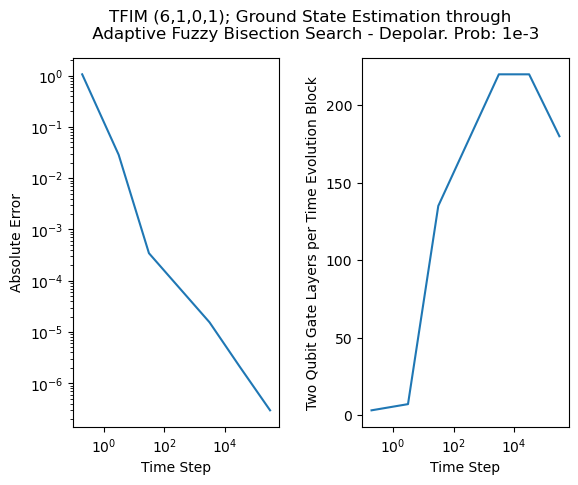

In [51]:
time_steps = [0.196, 3.1395, 31.396, 3139.593, 31395.93, 313959.265]
abs_errors= [1.06, 0.0286, 3.44e-4, 1.547e-05, 2.1e-06, 2.97e-07]
layers_per_U = [3, 7, 135, 220, 220, 180]

fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel("Time Step")
ax[0].set_ylabel("Absolute Error")
fig.suptitle("TFIM (6,1,0,1); Ground State Estimation through \n Adaptive Fuzzy Bisection Search - Depolar. Prob: 1e-3")
ax[0].plot(time_steps, abs_errors)

ax[1].set_yscale('linear')
ax[1].set_xscale('log')
ax[1].set_xlabel("Time Step")
ax[1].set_ylabel("Two Qubit Gate Layers per Time Evolution Block")
ax[1].plot(time_steps, layers_per_U)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)

In [23]:
# We go one digit further, assuming we know the lower bound to be -7.75 through previous
# approximations!

dist = 0.001
max_spectrum_length = 0.1
ground_energy_lower_bound = -4.71 - max_spectrum_length
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound
c2 = c2

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

a_est = -0.23
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)
print("Exact a: ", a_values[0])
print("c1:", c1)

# Divide up the time step and repeat the circuit! Depolarizing error: 1e-2!
# As noise goes up, we shoot more shots: 1e5
#a_est = fuzzy_bisection_noisy(qc_qetu, L, J, g, 0,  1, 18, 1e-3, 0, c1, c2, a_values, 1e-2, qetu_initial_state=np.kron(ket_0, end_state_lind), nshots=1e5, split_U=1, RQC_layers=5, qetu_layers=5, ground_state=eigenvectors_sort[:, 0])

Absolute Error:  (3.0322223974877733+0j)
Estimated Eigenvalue:  -4.695184212824756
Exact a:  (-0.2413418426424419+0j)
c1: 31.39592653589793


In [19]:
# The run above will get stuck around the given interval.
# We demonstrate that we approximated the eigenvalue until the sixth digit!

a_est = 0.5
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)

Absolute Error:  (2.4951349858379928+0j)
Estimated Eigenvalue:  -5.232271624474537


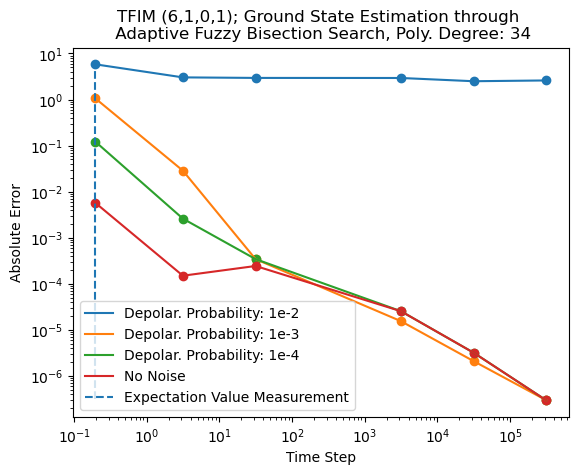

In [46]:
time_steps = [0.196, 3.1395, 31.396, 3139.593, 31395.93, 313959.265]
abs_errors_e3 = [1.06, 0.0286, 3.44e-4, 1.547e-05, 2.1e-06, 2.97e-07]
abs_errors_e2 = [5.82, 3.03, 2.95, 2.94, 2.5, 2.6]
abs_errors_e4 = [0.122, 0.0026, 3.44e-4, 2.547e-05, 3.2e-06, 2.96e-07]
abs_errors_ideal = [0.00573, 1.5e-4, 2.44e-4, 2.547e-05, 3.2e-06, 2.96e-07]

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Time Step")
plt.ylabel("Absolute Error")
plt.title("TFIM (6,1,0,1); Ground State Estimation through \n Adaptive Fuzzy Bisection Search, Poly. Degree: 34")
plt.plot(time_steps, abs_errors_e2, label="Depolar. Probability: 1e-2")
plt.plot(time_steps, abs_errors_e3, label="Depolar. Probability: 1e-3")
plt.plot(time_steps, abs_errors_e4, label="Depolar. Probability: 1e-4")
plt.plot(time_steps, abs_errors_ideal, label="No Noise")
plt.axvline(x=time_steps[0], ymin=0.05, ymax=0.95, ls="--", label="Expectation Value Measurement")

plt.scatter(time_steps, abs_errors_e2)
plt.scatter(time_steps, abs_errors_e3)
plt.scatter(time_steps, abs_errors_e4)
plt.scatter(time_steps, abs_errors_ideal)
plt.legend()

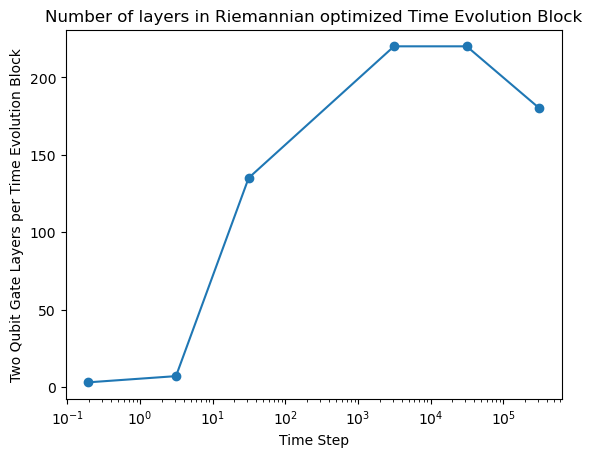

In [51]:
plt.xlabel("Time Step")
plt.ylabel("Two Qubit Gate Layers per Time Evolution Block")
plt.title("Number of layers in Riemannian optimized Time Evolution Block")
plt.xscale('log')
layers_per_U = [3, 7, 135, 220, 220, 180]
plt.plot(time_steps, layers_per_U)
plt.scatter(time_steps, layers_per_U)

(-1.5, 1.5)

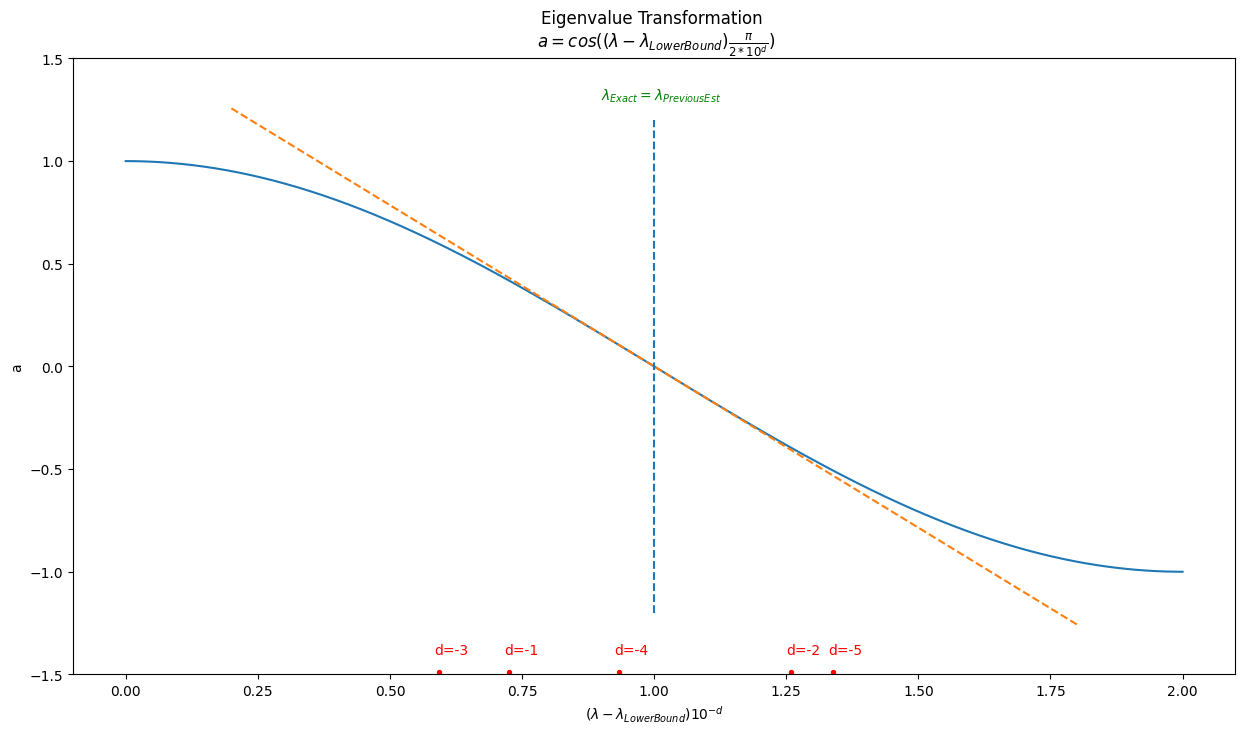

In [175]:
x_values = np.linspace(0, 2, 1001)
plt.figure(figsize=(15, 8))
plt.ylabel("a")
plt.xlabel(r'$ (\lambda-\lambda_{LowerBound}) 10^{-d} $') 
plt.plot(x_values, np.cos(np.pi/2 * x_values))
plt.title("Eigenvalue Transformation \n" + r" $ a = cos((\lambda-\lambda_{LowerBound}) \frac {\pi}{2*10^{d}}) $")

plt.plot(x_values[100:-100], -np.pi/2 * (x_values[100:-100]-1), ls="--")

for d, x in enumerate(x_exp[1:]):
    plt.annotate(f"d={-(d+1)}", xy=(x-0.01,-1.4), color="red")
plt.axvline(x=1, ymin=0.1, ymax=0.9, ls="--", label="Expectation Value Measurement")
plt.annotate(r"$ \lambda_{Exact} = \lambda_{Previous Est} $", xy=(0.9,1.3), color="green")

plt.scatter(x_exp[1:], [-1.49 for i in range(len(x_exp)-1)], s=8, color="red")
plt.ylim([-1.5, 1.5])

# d=-1 means: First digit after floating point is known, we are trying to estimate the second digit etc. 

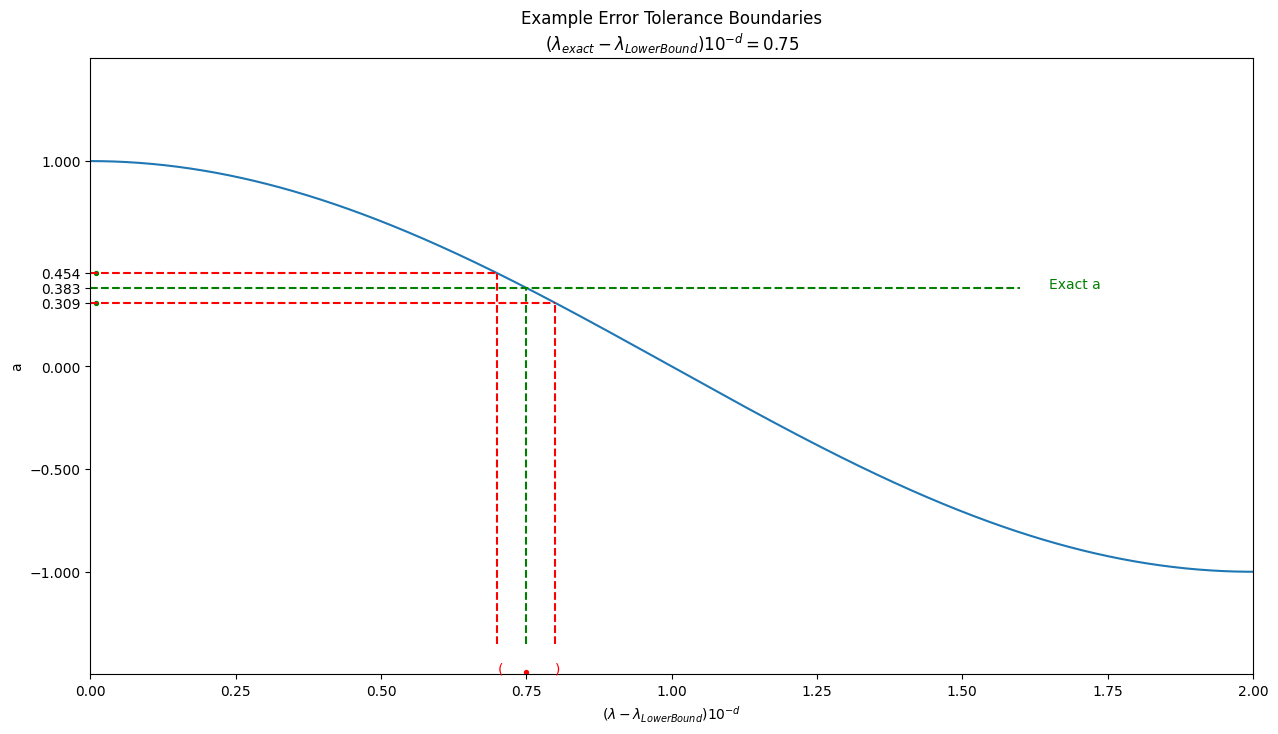

In [169]:
x_values = np.linspace(0, 2, 1001)
plt.figure(figsize=(15, 8))
plt.ylabel("a")
plt.xlabel(r'$ (\lambda-\lambda_{LowerBound}) 10^{-d} $') 
plt.plot(x_values, np.cos(np.pi/2 * x_values))
plt.title("Example Error Tolerance Boundaries\n" + r"$ (\lambda_{exact}-\lambda_{LowerBound}) 10^{-d} = 0.75 $")

plt.scatter([0.75], [-1.49], s=8, color="red")
plt.annotate("(", xy=(0.75-0.05, -1.49), color="red")
plt.annotate(")", xy=(0.75+0.05, -1.49), color="red")
plt.ylim([-1.5, 1.5])
plt.xlim([0, 2])

plt.axvline(x=0.75-0.05, ymin=0.05, ymax=0.65, ls="--", color="red")
plt.axvline(x=0.75+0.05, ymin=0.05, ymax=0.6, ls="--", color="red")

plt.axhline(y= np.cos(np.pi/2 * 0.7), xmin=0, xmax= 0.7/2, ls="--", color="red")
plt.axhline(y= np.cos(np.pi/2 * 0.8), xmin=0, xmax= 0.8/2, ls="--", color="red")
plt.axhline(y= np.cos(np.pi/2 * 0.75), xmin=0, xmax= 0.8, ls="--", color="green")
plt.annotate("Exact a", xy=(1.65, np.cos(np.pi/2 * 0.75)), color="green")
plt.axvline(x=0.75, ymin=0.05, ymax=0.625, ls="--", color="green")

plt.yticks([np.cos(np.pi/2 * 0.8), np.cos(np.pi/2 * 0.7), 1, -1, 0, -0.5, np.cos(np.pi/2 * 0.75)])

plt.scatter([0.01, 0.01], [np.cos(np.pi/2 * 0.7), np.cos(np.pi/2 * 0.8)], color="green", s=8)

# d=-1 means: First digit after floating point is known, we are trying to estimate the second digit etc. 